# 0.0 Imports

In [92]:
 import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from IPython.display import HTML
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()    

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv')

df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Descrição dos dados

## 1.1. Rename Columns

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
# Rename Columns
cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

df1.columns = cols_new

df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
49551,540521,21080,SET/20 RED RETROSPOT PAPER NAPKINS,12,7-Jan-17,0.85,12651.0,France


In [7]:
df_raw.sample()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
382815,569962,21539,RED RETROSPOT BUTTER DISH,6,4-Oct-17,4.95,13993.0,United Kingdom


## 1.2. Data Dimensions

In [8]:
print( 'Number of rows: {}'.format ( df1.shape[0] ) )
print( 'Number of cols: {}'.format ( df1.shape[1] ) )


Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
# Precisamos resolver o problema do NA


In [12]:
df_missing = df1.loc[ df1['customer_id'].isna(), : ]
df_not_missing = df1.loc[~df1['customer_id'].isna(), : ]

In [13]:
# Create Reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000 +len( df_backup),1)

# Merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on= 'invoice_no', how= 'left' )

# Coalesce
df1[ 'customer_id'] = df1['customer_id_x'].combine_first( df1[ 'customer_id_y' ] )

# Drop extra columns

df1 = df1.drop( columns = ['customer_id_x', 'customer_id_y'], axis = 1)


In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change Dtypes

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [16]:
# Invoice Date

df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y')

# Customer Id

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [17]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y')

# Customer Id

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = [ 'int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [20]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max( ) - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew( ) ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# Concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611121,2.08,96.759763,186.506973,59005.719804
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color= 'red'> 1.7.1.1 Numerical Attributs - Investigating </f>

- Quantity negativa ( pode ser devolução )
- Preço unitário igual a zero ( pode ser promoção )

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


###  Invoice_No

In [22]:
# Problema: Temos invoice com letras e números

# Identificação >

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x : bool( re.search( '[^0-9]+', x ) ) ), :]

print('Total number of invoices: {}'.format( len( df_letter_invoices )))  
print('Total number of negative quantity: {}'.format( len(df_letter_invoices[ df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


### Stock Code

In [23]:
# Check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x : bool( re.search( '^[a-zA-Z]+$', x ) ) ) ,'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Description

In [24]:
df1.head()

#  Ação: Delete Description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


### Country

In [25]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [26]:
df1['country'].value_counts( normalize = True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [27]:
df1[['customer_id','country']].drop_duplicates().groupby( 'country').count().reset_index().sort_values( 'customer_id', ascending = False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Filtragem de Variáveis

In [28]:
df2 = df1.copy()

In [29]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [30]:
 # === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]


# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]





# 3.0. Feature Engineering

In [31]:
#verificar as celulas

In [32]:
# Feature Ideas:
## Moving Average - 7d, 14d, 30d
## Quantidade de compras por mês, antes do dia 15 e depois do dia 15
## Average Financial
## Basket size * Price - quantidade

In [33]:
df3 = df2.copy()

## 3.1. Feature Creation

In [34]:
# Data Reference

df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1 Gross Revenue

In [35]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

df_ref.isna().sum()

/home/leandro/.pyenv/versions/pa005insiderscluestering/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day from last purchase

In [36]:
 # Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of itens purchased

In [37]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4 Quantity of total products purchased

In [38]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.4.1 Quantity of products purchased

In [39]:
 # Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.5 Average Ticket

In [40]:
# Average Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename ( columns = {'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how ='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6 Average Recency Days

In [41]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Number of  returns

In [42]:
# Number of Returns
df_returns = df2_returns [[ 'customer_id', 'quantity']].groupby( 'customer_id').sum().reset_index().rename( columns ={'quantity': 'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how = 'left', on= 'customer_id')
df_ref.loc[ df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0


df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
qtde_returns           0
dtype: int64

In [43]:
# Number of Returns
df2_returns [[ 'customer_id', 'quantity']].groupby( 'customer_id').sum().reset_index().rename( columns ={'quantity': 'qtde_returns'} )
                 

,customer_id,qtde_returns
0,12346,-74215
1,12352,-63
2,12359,-10
3,12362,-17
4,12375,-1
5,12379,-1
6,12380,-1
7,12381,-25
8,12383,-3
9,12384,-5


### 3.1.8  Unique Basket Size - Quantidade de itens distintos por compra

- Invoice_no = Purchase
- Stock code = Product
- Quantity = Item

In [44]:
df_aux = ( df2_purchases.loc[ :, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id')
                                                                           .agg( n_purchase = ( 'invoice_no', 'nunique',),
                                                                                 n_products = ( 'stock_code', 'count') )
                                                                           .reset_index() )      
# Calculation
df_aux['avg_unique_basket_size'] = df_aux[ 'n_products'] / df_aux[ 'n_purchase']

# Merge
df_ref = pd.merge( df_ref, df_aux[[ 'customer_id', 'avg_unique_basket_size']], how= 'left', on= 'customer_id' )

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
qtde_returns                 0
avg_unique_basket_size      91
dtype: int64

### 3.1.9 Basket Size - Quantidade de itens por cesta ( Quantity )

- Invoice_no = Purchase
- Stock code = Product
- Quantity = Item

In [45]:
df_aux = ( df2_purchases.loc[ :, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id')
                                                                           .agg( n_purchase = ( 'invoice_no', 'nunique',),
                                                                                 n_products = ( 'quantity', 'sum') )
                                                                           .reset_index() )      
# Calculation
df_aux['avg_basket_size'] = df_aux[ 'n_products'] / df_aux[ 'n_purchase']

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how= 'left', on= 'customer_id' )

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
qtde_returns                 0
avg_unique_basket_size      91
avg_basket_size             91
dtype: int64

### 3.1.10 Frequency Purchase

In [46]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby( 'customer_id')
                                                            .agg( max_ = ( 'invoice_date', 'max' ),
                                                                  min_ = ( 'invoice_date', 'min'),
                                                                  days_ = ('invoice_date', lambda x : ( ( x.max()- x.min() ).days) + 1 ) ,
                                                                  buy_ = ( 'invoice_no', 'count') ) ).reset_index()


# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply ( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
qtde_returns                 0
avg_unique_basket_size      91
avg_basket_size             91
frequency                   91
dtype: int64

In [47]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,40.0,8.735294,50.970588,17.000000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,35.0,19.000000,154.444444,0.028302
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,50.0,15.466667,335.200000,0.040323
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0,5.600000,87.800000,0.017921
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,22.0,1.000000,26.666667,0.073171


In [48]:
df3 = df_ref.copy()

# 4.0. Exploratory Data Analysis

In [49]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
qtde_returns              0
avg_unique_basket_size    0
avg_basket_size           0
frequency                 0
dtype: int64

## 4.1 Univariate Analysis

### Metricas para olharmos

1- Clusters coesos - Separados

2- Métricas:
    - Min, Máximo, Range( dispersão )
    
    - Média e Mediana
    
    - Desvio Padrão e Variância
    
    - Coeficiente de Variação ( CV )
    
    - Distribuição
    

In [50]:
#profile = ProfileReport(df4,html={'style':{'full_width':True}})
#profile.to_file('output.html')
#profile.to_notebook_iframe()

### 4.1.1 Gross revenue

In [51]:
df4.sort_values( 'gross_revenue', ascending = False).head(10)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,288.0,28.611111,2733.944444,0.203390
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.0,7.183333,1068.733333,0.163043
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,952.0,7.326087,1521.586957,0.127778
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,3332.0,28.507538,403.331658,0.533512
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,427.0,35.650000,3868.650000,0.063694
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,7.260000,859.0,25.454545,1052.454545,0.151515
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,11.593750,1535.0,31.064516,2082.225806,0.083333
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.415311,9.054054,8004.0,3.887097,648.500000,0.184524
955,16684,66653.56,4.0,28.0,50255.0,277.0,240.626570,22.125000,864.0,9.892857,1794.821429,0.078873
36,13694,65039.62,3.0,50.0,63312.0,568.0,114.506373,9.736842,1504.0,11.360000,1266.240000,0.134771


In [52]:
df3[ df3[ 'customer_id' ] == 14646].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,288.0,28.611111,2733.944444,0.20339


### 4.1.2 Qtde Itens

In [53]:
df4[df4[ 'qtde_items' ] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,288.0,28.611111,2733.944444,0.20339


### 4.1.3 Qtde Produtos

In [54]:
#df4[df4['qtde_products'] == 7838]
df3[df3['customer_id'] == 17841].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,203.0,63.209677,185.91129,0.33244


### 4.1.4 Avg ticket

In [55]:
df3[ df3['customer_id'] == 16446]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency


### 4.1.4 Frequency

In [56]:
 #df4[df4['frequency'] == 17]
df3[df3['customer_id'] == 17850]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.5,40.0,8.735294,50.970588,17.0


### 4.1.5 Average Basket Size

In [57]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency


## 4.2 Bivariate Analysis

In [58]:
cols = ['customer_id']
df42 = df4.drop( cols, axis = 1)

<Figure size 1800x864 with 0 Axes>

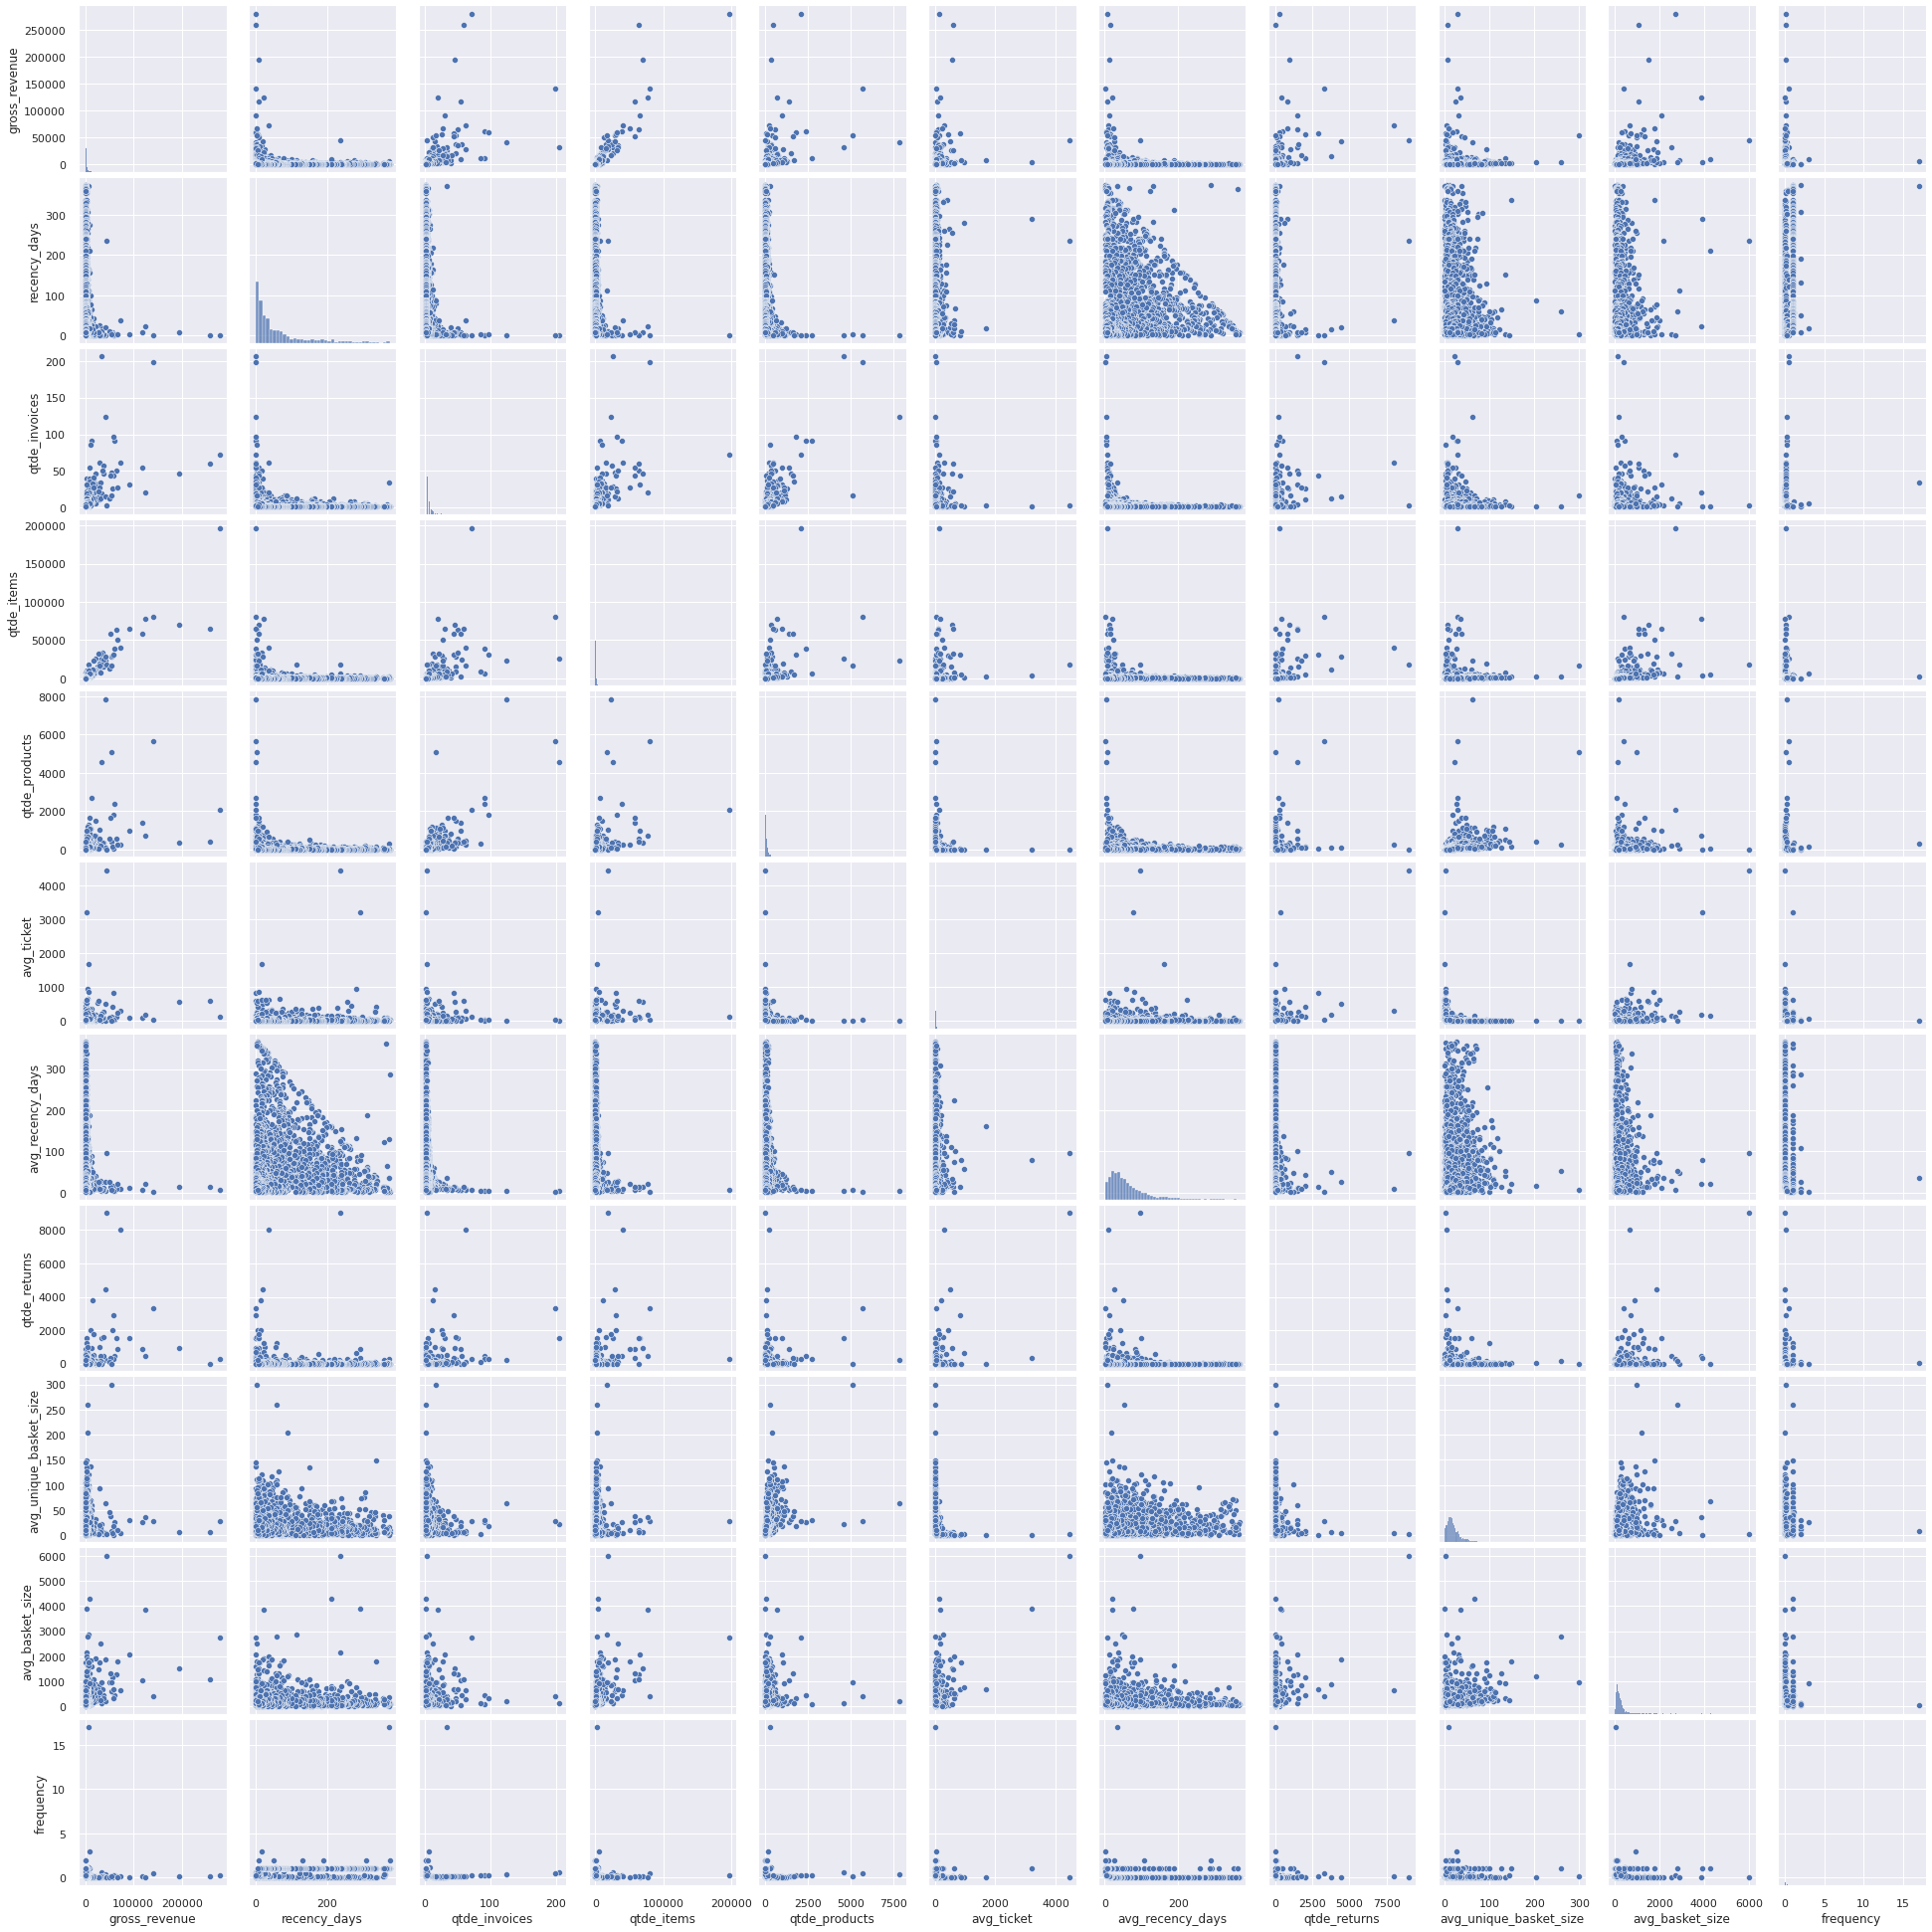

In [59]:
plt.figure( figsize = ( 25,12 ) )
sns.pairplot( df42  );

## 4.3 Estudo do Espaço

In [60]:
df43 = df4.drop( columns = ['customer_id'], axis = 1 ).copy()

In [61]:
df43.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
0,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,40.0,8.735294,50.970588,17.000000
1,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,35.0,19.000000,154.444444,0.028302
2,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,50.0,15.466667,335.200000,0.040323
3,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0,5.600000,87.800000,0.017921
4,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,22.0,1.000000,26.666667,0.073171


In [62]:
mm = pp.MinMaxScaler()


#
df43[ 'gross_revenue' ]        = mm.fit_transform( df43 [['gross_revenue']])
df43[ 'recency_days' ]         = mm.fit_transform( df43[['recency_days']])
df43[ 'qtde_invoices' ]        = mm.fit_transform( df43[['qtde_invoices']])
df43[ 'qtde_items']            = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']])
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])


X = df43.copy()

In [63]:
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,qtde_returns,avg_unique_basket_size,avg_basket_size,frequency
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.003595,0.094521,0.004438,0.025896,0.008317,1.000000
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.003764,0.071918,0.003883,0.060260,0.025539,0.001345
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.006010,0.060788,0.005547,0.048431,0.055623,0.002052
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.007125,0.251142,0.000000,0.015400,0.014447,0.000734
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.002441,0.000000,0.004272,0.003985


### 4.3.1 PCA

In [64]:
X.shape[1]

11

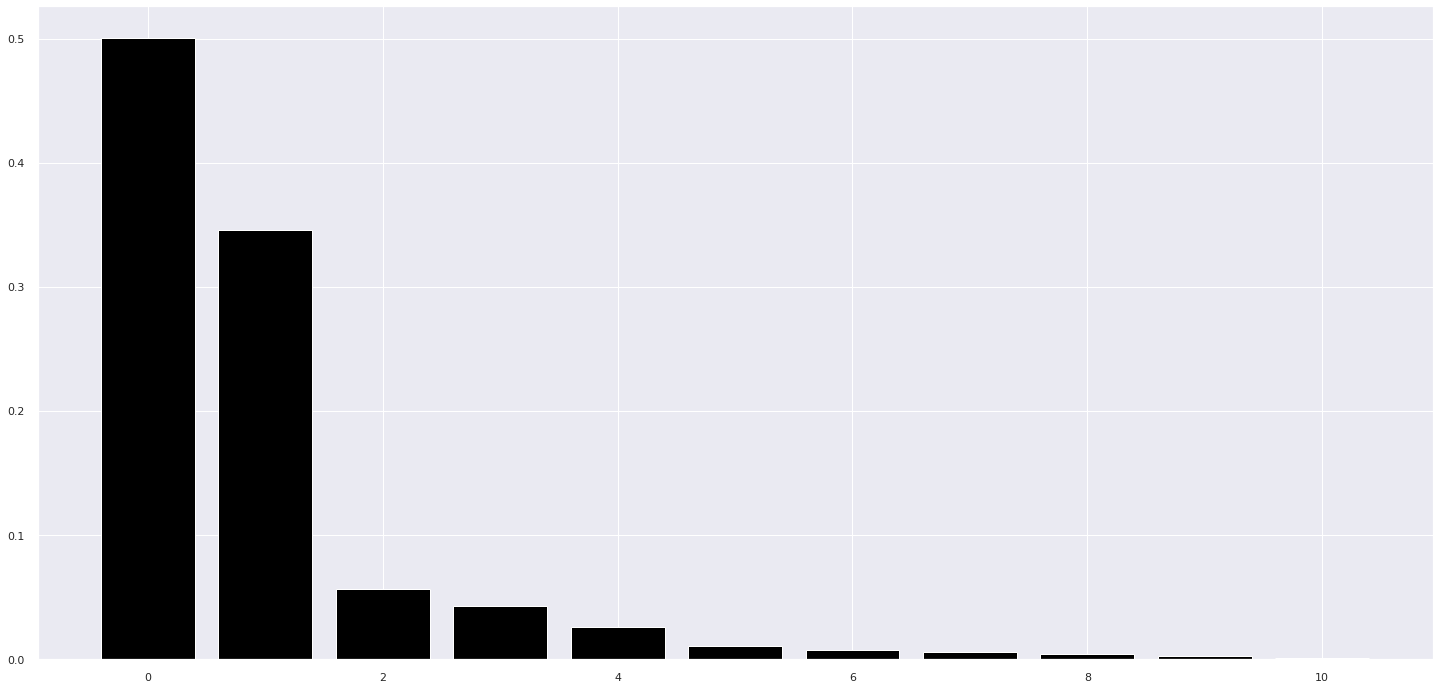

In [65]:
pca = dd.PCA( n_components = X.shape[1] )
principal_components = pca.fit_transform( X )


# Plot explained variable
features = range ( pca.n_components_ )
plt.bar( features, pca.explained_variance_ratio_, color = 'black' );

#pca component
df_pca = pd.DataFrame( principal_components)

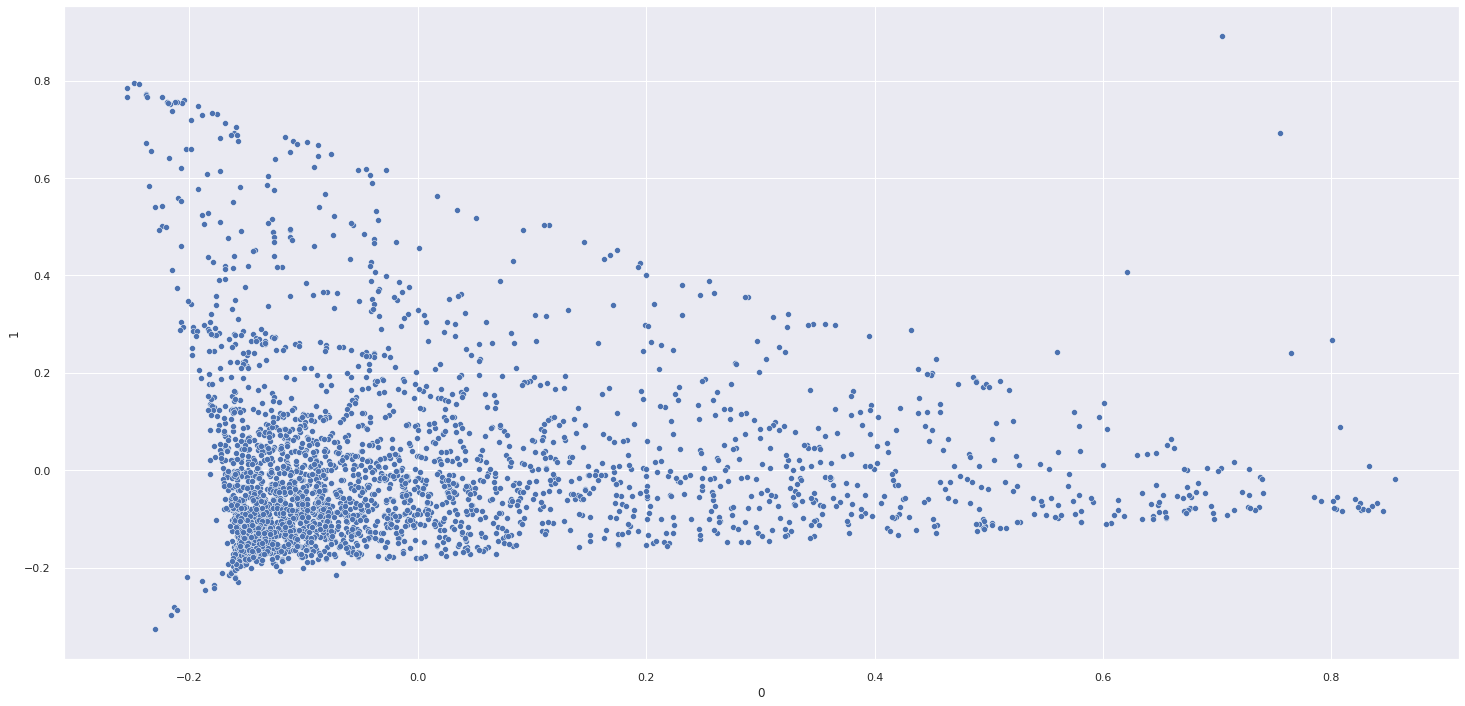

In [66]:
sns.scatterplot( x=0, y = 1, data = df_pca);

In [67]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.856032,-0.018876,0.044032,0.107428,-0.133946,0.051341,-0.186189,0.945727,0.038060,-0.014428,-0.004511
1,-0.009760,-0.112148,-0.014825,0.001486,-0.014610,0.003567,0.001839,-0.005976,0.000141,-0.002466,0.001499
2,-0.153584,-0.143638,-0.006936,0.037476,-0.005276,-0.001677,-0.014919,-0.002702,-0.007655,-0.008061,-0.002635
3,0.075959,0.079473,-0.053215,0.022347,-0.009995,-0.000006,0.000125,-0.006656,0.000919,-0.000395,0.000129
4,0.736568,-0.075356,-0.039723,0.035938,-0.010376,0.019349,0.008958,-0.030703,0.046670,-0.009116,-0.008029


### 4.3.2 UMAP

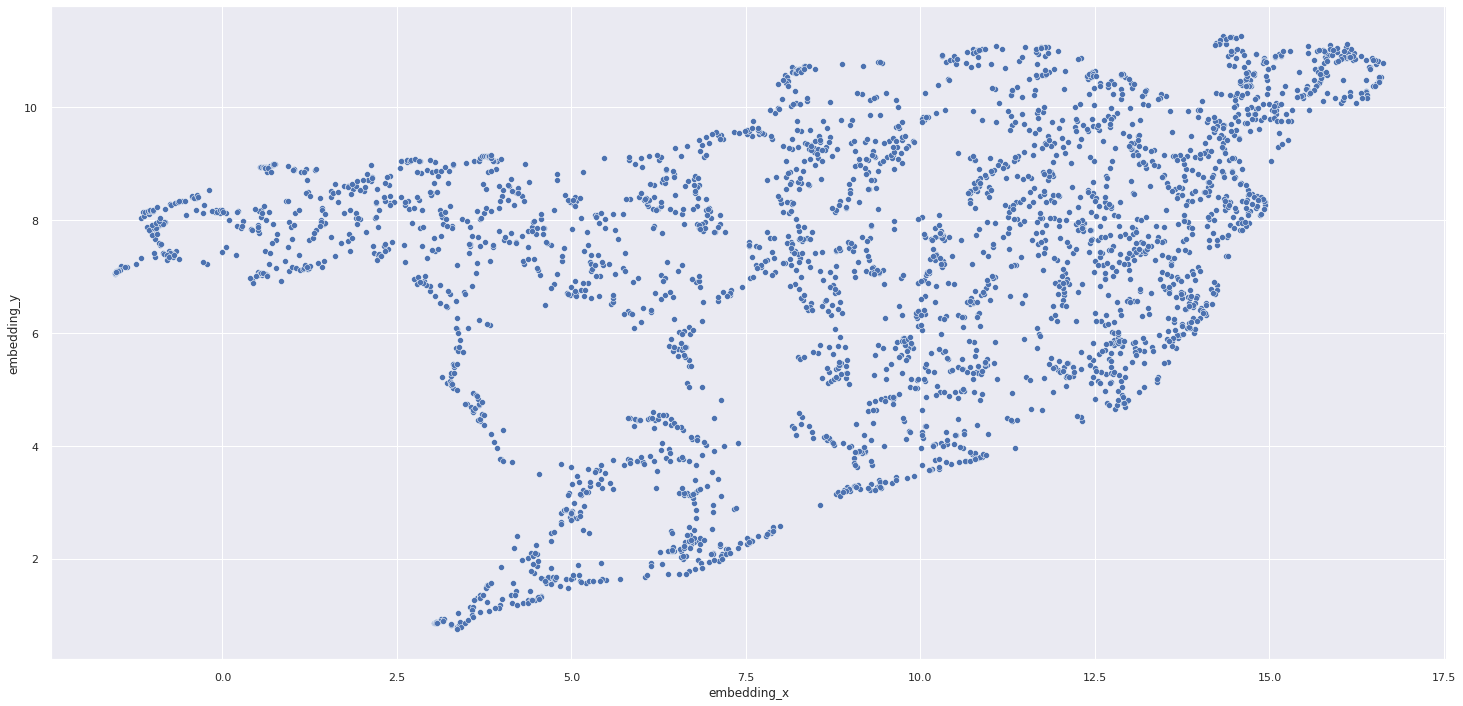

In [68]:
reducer = umap.UMAP(random_state= 42)
embedding = reducer.fit_transform( X )

# embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot ( x = 'embedding_x', y = 'embedding_y',
                data= df_pca);

### 4.3.3 T-SNE

/home/leandro/.pyenv/versions/pa005insiderscluestering/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/leandro/.pyenv/versions/pa005insiderscluestering/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

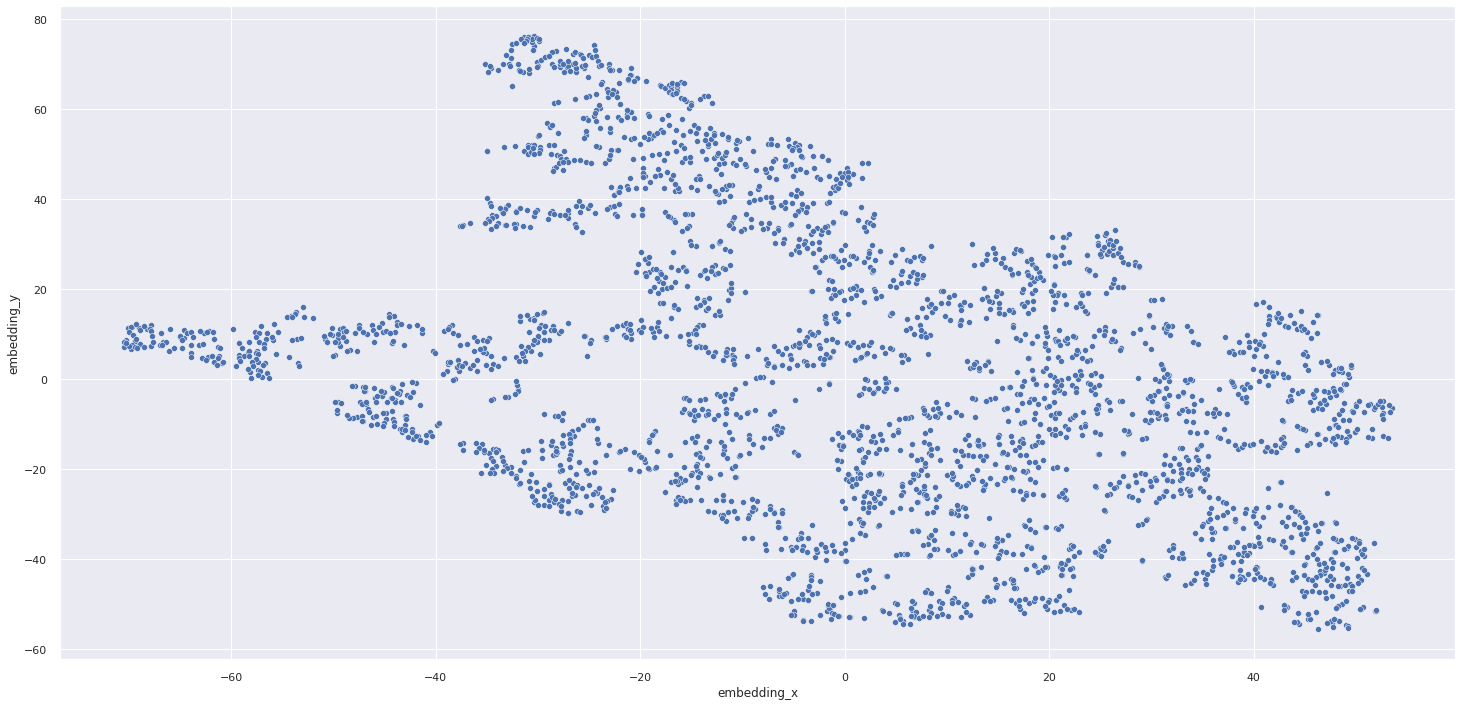

In [69]:
reducer = TSNE(n_components = 2,
                    n_jobs = -1,
                    random_state= 42)
embedding = reducer.fit_transform( X )

# embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot ( x = 'embedding_x', y = 'embedding_y',
                data= df_pca)

### 4.3.4 Tree-Based embedding

In [70]:
from sklearn import ensemble as en

In [71]:
# Training dataset

X = df4.drop( columns = ['customer_id', 'gross_revenue'], axis = 1 )
y = df4['gross_revenue']

# Model definittion
rf_model = en.RandomForestRegressor ( n_estimators = 100, random_state= 42)

# Model trainning
rf_model.fit( X,y)

#Leaf

# DataFrame Leaf



RandomForestRegressor(random_state=42)

In [73]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [74]:
X.shape

(2968, 10)

In [75]:
df_leaf.shape

(2968, 100)

In [76]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,3177,3326,3337,2763,3147,3227,3131,3166,3363,3155,3306,3093,3189,2800,3205,3010,3176,3124,3268,3065,3078,2905,3298,3359,3362,3270,2862,3089,3041,3310,3382,3374,3336,2959,3243,3410,3122,2957,3029,3278,3247,3221,3134,3180,3142,3285,3335,3346,3128,3193,2920,3139,3389,3379,3204,3170,3360,2925,2976,3421,2888,3336,3251,2713,3041,3301,3327,3084,3303,3344,2990,2702,3262,3138,3159,3304,3105,3216,3048,3237,3238,3137,3083,3290,3098,3285,3161,3132,3272,3184,3173,3210,3059,3041,3126,3186,2832,3356,3326
1,2961,2923,3039,2968,2752,3131,2922,2830,3112,2853,3101,2564,2551,3115,2748,3121,2984,3047,3064,2756,2954,3025,2735,2846,3016,2916,2841,2780,3086,3028,2869,3016,2968,2747,2920,2970,2854,2813,3051,3019,2972,2779,3192,3110,3113,2763,2913,2873,2977,3104,3165,3005,3057,2960,2991,2961,3128,3017,2854,2960,2994,2815,2897,2873,2999,3028,2978,2902,3044,2914,2956,2974,3143,2929,3043,2786,2901,3071,3161,3023,2919,2894,2982,2583,2906,3088,2947,3152,3092,2850,2516,2888,2882,2993,3145,3014,2907,2798,2972,2816
2,3632,3609,3586,3411,3572,3659,3635,3545,3679,3614,3625,3578,3528,3652,3566,3566,3583,3656,3551,3466,3512,3633,3604,3522,3562,3669,3573,3598,3592,3719,3432,3672,3599,3643,3575,3611,3545,3521,3598,3483,3653,3403,3615,3509,3520,3600,3425,3649,3635,3546,3627,3503,3570,3610,3666,3630,3609,3651,3573,3572,3617,3585,3573,3689,3453,3628,3652,3494,3554,3633,3587,3427,3572,3605,3543,3541,3598,3563,3537,3497,3432,3458,3567,3427,3514,3598,3583,3699,3599,3557,3597,3435,3561,3482,3604,3459,3525,3620,3568,3654
3,1279,1412,1758,1492,2021,1460,2107,1461,1665,1717,2044,2296,1345,1597,1522,1985,1921,1600,1923,1411,1835,1429,1464,1504,1156,1479,1509,1527,1982,1313,1945,1531,1505,1450,1541,1556,2164,2205,1660,1480,1495,1471,1462,1809,1526,1496,1444,1433,1370,1664,1813,1493,1350,2225,2104,1493,1556,1738,1298,2125,1483,1903,1888,1809,1484,1487,1392,1761,1065,1362,2301,1584,2180,2173,1273,2040,2042,1494,1917,1467,1918,1418,1520,1636,1482,1488,2050,1342,1661,1543,1875,1744,2027,1886,1936,2266,1470,1195,1983,2111
4,354,716,579,697,137,705,731,683,191,197,580,722,663,195,569,611,575,421,552,413,577,714,416,200,630,210,437,205,147,729,703,201,211,203,233,717,595,203,703,973,516,876,217,591,894,675,285,603,685,606,594,185,752,417,209,550,699,665,720,603,231,730,189,206,667,456,475,560,456,203,712,230,550,623,708,199,718,180,111,226,213,696,758,218,681,163,305,725,689,807,331,192,579,541,196,131,188,704,706,175


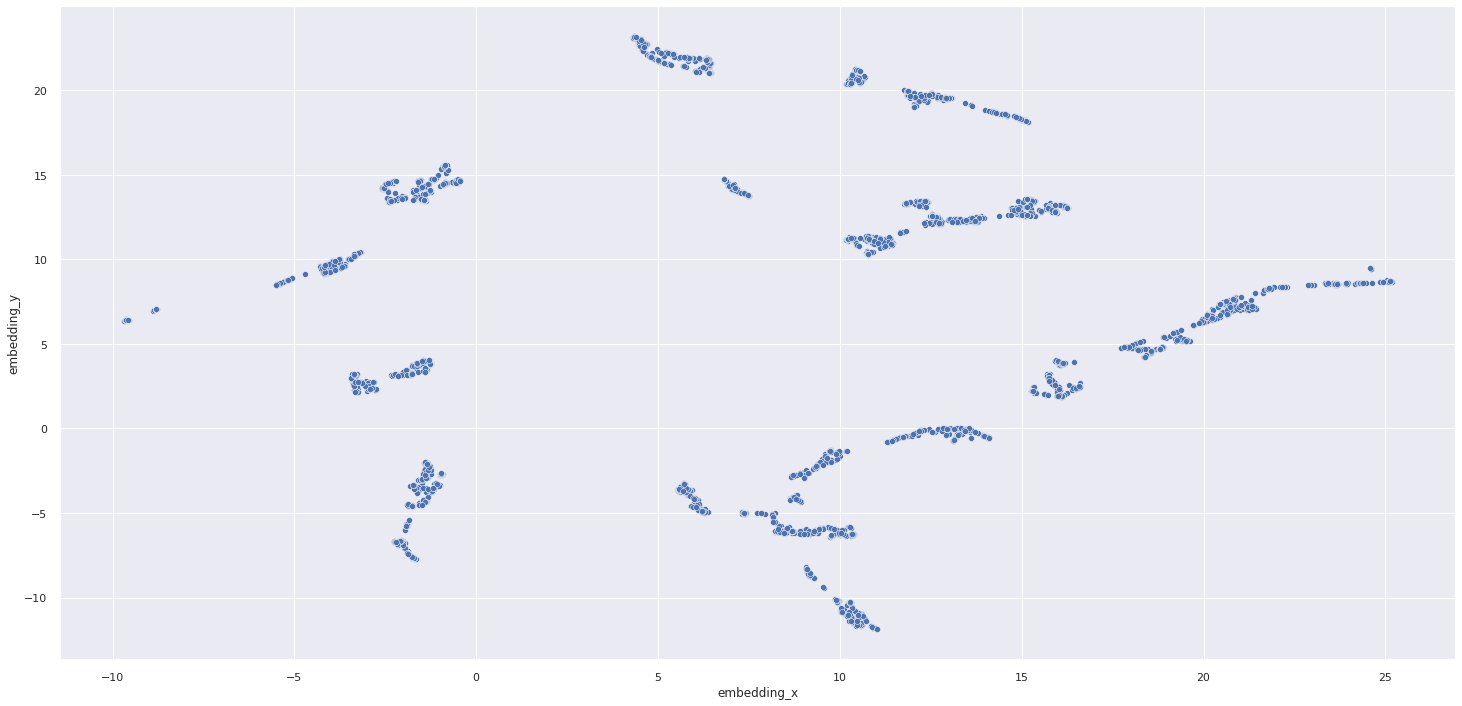

In [327]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca );


# 5.0. Data Preparation

Padronização/ normalização ( Standardization ) -> Premissa de que os dados vieram de uma distribuição normal.


Rescala ( Rescale) -> Não premissa de que os dados vieram de uma distribuição normal.

**Regra do Coração**
- 1- Distribuição Normal e não possui outlier -> Standart Scaler - Médio e desvio Padrão
- 2- Distribuição Normal e possui outlier -> Robust Scaler - Quartis
- 3- Não distribuição norma -> Min Max Scaler

**Teste de Normalidade**
- QQ Plot - Quantile Quantile Plot ( Quantile teorica x Quantile real)

- Ks teste- Kolgomorov Smirnoff ( Teste de hipótese ) Se p-value > 0.5 -> Distribuição Normal, p- Value < 0.5 -> Não distribuição normal

**Detecção Outlier**
- Box plot -> Pontos são identificados como outliers
- IRQ * 2.5 -> Acima desse valor ( outlier )

- Z-Score > 3 -> Outliers
- Z-Score > -3 -< Outliers





In [328]:
df5 = df_tree.copy()

In [329]:
df5.head()

,embedding_x,embedding_y
0,-5.434389,8.547874
1,-2.569062,14.138089
2,-1.873227,-5.498095
3,25.112038,8.696949
4,9.065816,-8.257551


In [330]:
# ## Standar Scakaler
# mm = pp.MinMaxScaler()
# ss = pp.StandardScaler()
# rs = pp.RobustScaler()



# df5['gross_revenue'] = mm.fit_transform ( df5[['gross_revenue']])
# df5['recency_days'] = mm.fit_transform ( df5[['recency_days']])
# #df5['qtde_invoices'] = mm.fit_transform ( df5[['qtde_invoices']])
# #df5['qtde_items'] = mm.fit_transform ( df5[['qtde_items']])
# df5['qtde_products'] = mm.fit_transform ( df5[['qtde_products']])
# #df5['avg_ticket'] = mm.fit_transform ( df5[['avg_ticket']])
# #df5['avg_recency_days'] = mm.fit_transform ( df5[['avg_recency_days']])
# df5['qtde_returns'] = mm.fit_transform ( df5[['qtde_returns']])
# df5['avg_unique_basket_size'] = mm.fit_transform ( df5[['avg_unique_basket_size']])
# #df5['avg_basket_size'] = mm.fit_transform ( df5[['avg_basket_size']])
# #df5['frequency'] = mm.fit_transform ( df5[['frequency']])


KeyError: "None of [Index(['gross_revenue'], dtype='object')] are in the [columns]"

# 6.0. Feature Selection

In [280]:
#cols_selected = [ 'customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [331]:
#df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

# 7.0. Hyperparameter Fine-tuning

In [332]:
df7 = df6.copy()

In [334]:
#X = df7.drop( columns=['customer_id'] )
X = df7.copy()

In [363]:
# How cluster we needs
#clusters = [ 2 , 3 , 4 , 5 , 6, 7 ]
clusters = np.arange( 2, 26, 1)

## 7.1 K-Means

In [364]:
kmeans_list = [ ]
for k in clusters:
    
    # Model definition
    kmeans_model = c.KMeans( n_clusters = k)
    
    # Model training
    kmeans_model.fit( X )
    
    # Model predict
    labels = kmeans_model.predict( X )
    
    # Model performace
    sil = m.silhouette_score( X, labels, metric = 'euclidean')
    kmeans_list.append( sil )
    
    
    

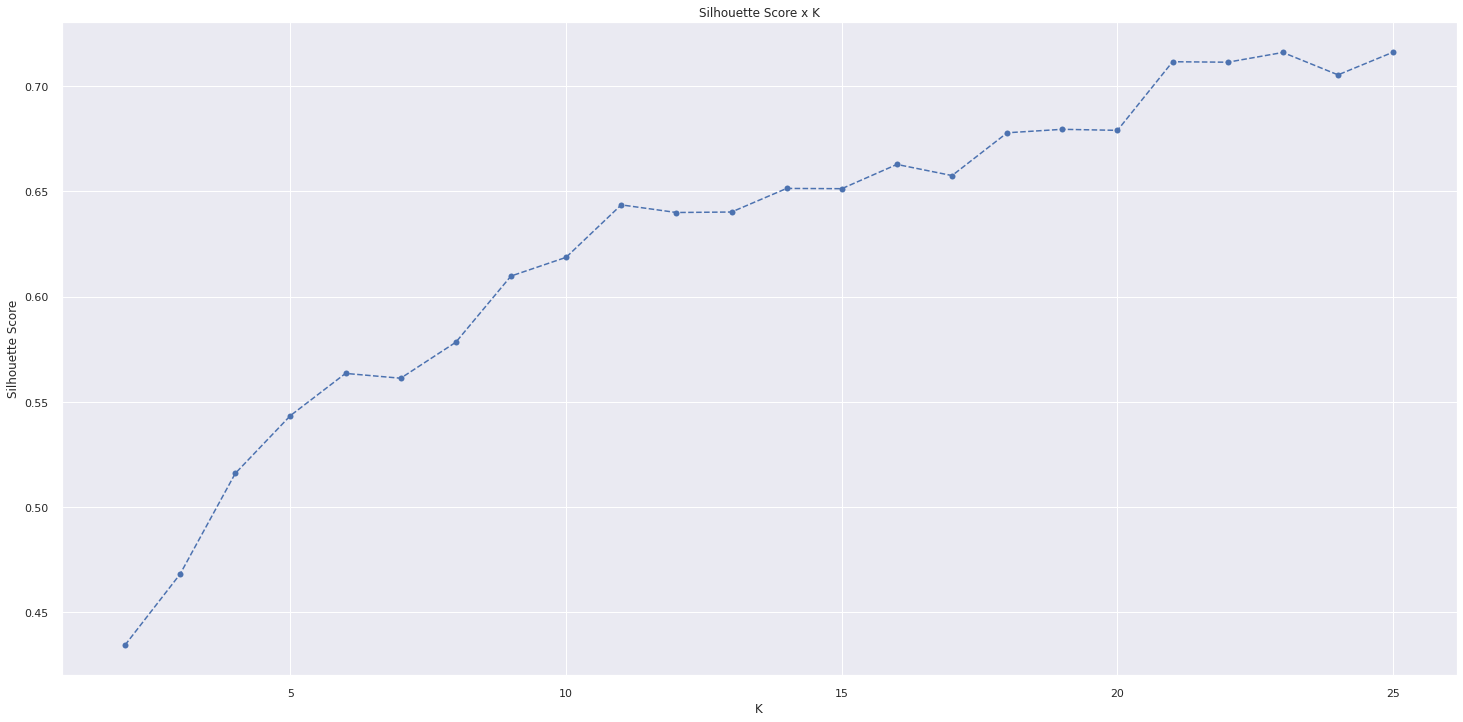

In [365]:
plt.plot( clusters, kmeans_list, linestyle = '--', marker = 'o', color= 'b');
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 GMM

In [366]:
gmm_list = []
for k in clusters:
    
    # Model definition
    gmm_model = mx.GaussianMixture( n_components = k )
    
    # Training model
    gmm_model.fit( X )
    
    # Model predict
    labels = gmm_model.predict( X )
    
    # Model performace
    sil = m.silhouette_score( X, labels, metric = 'euclidean')
    gmm_list.append( sil )
    

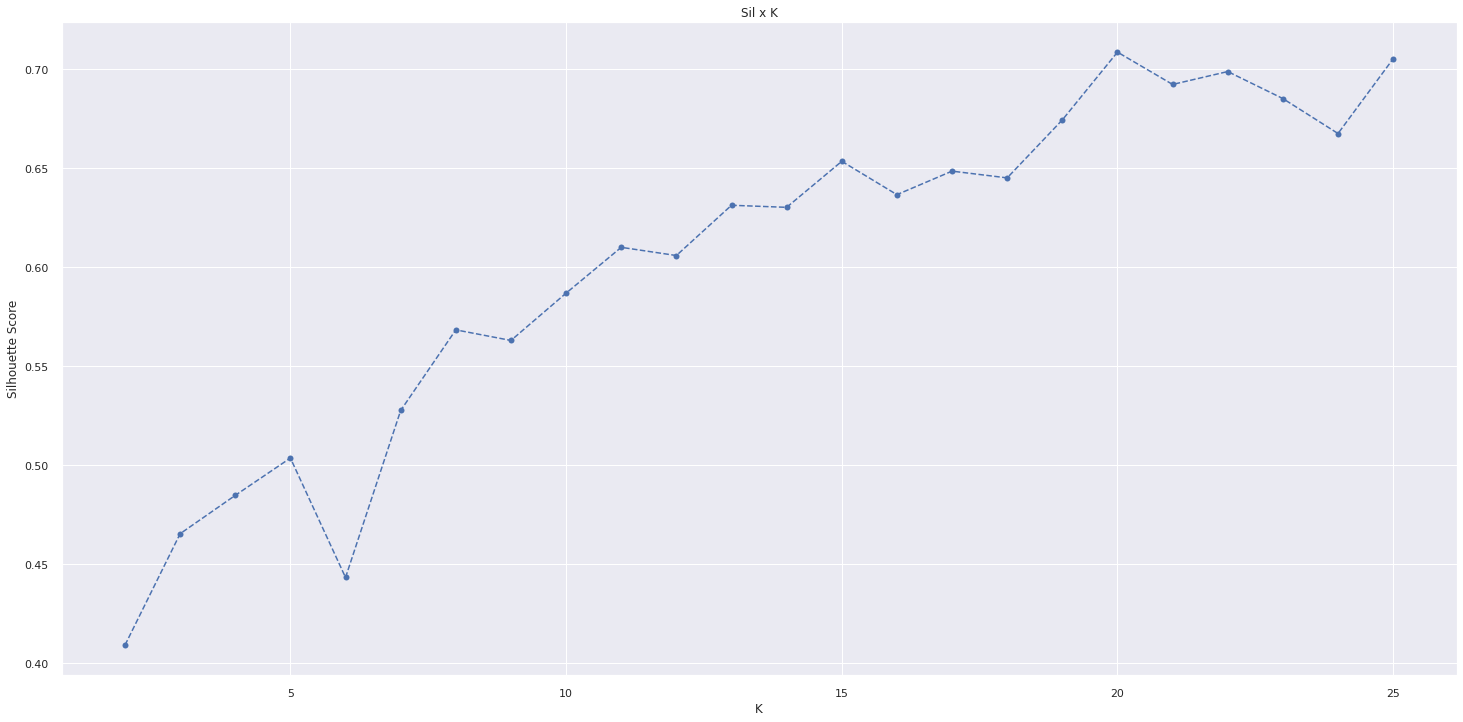

In [367]:
plt.plot( clusters, gmm_list, linestyle= '--', marker = 'o', color= 'b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

In [368]:
from scipy.cluster import hierarchy as hc

In [369]:
# Model defiintion and training
hc_model = hc.linkage( X, 'ward')

[]

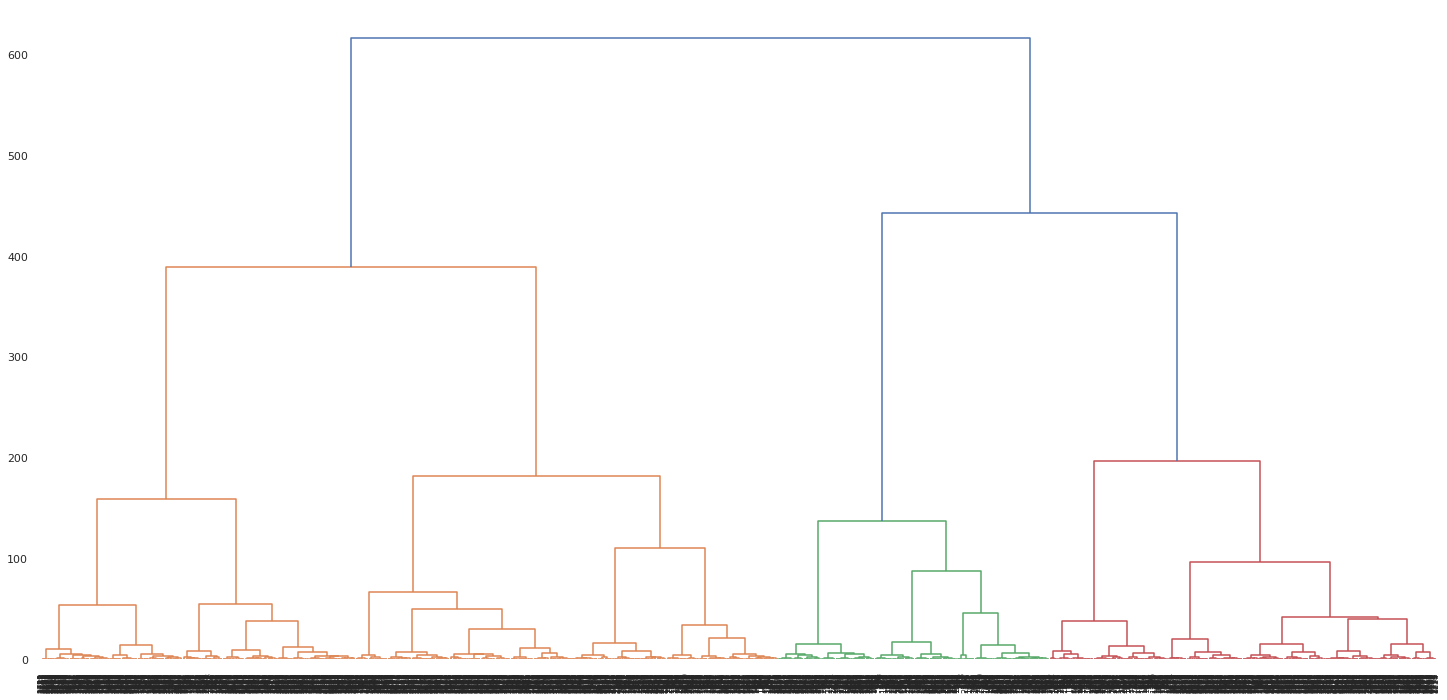

In [370]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

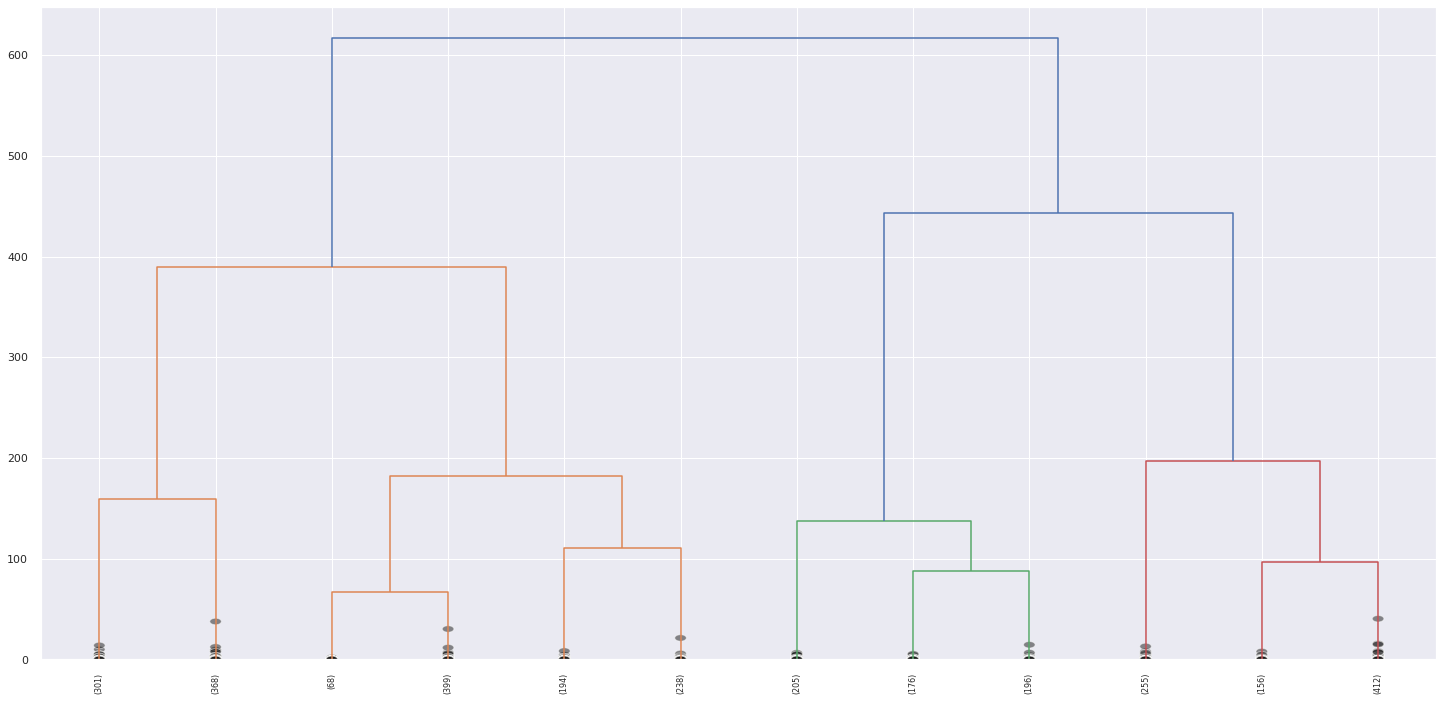

In [371]:
 hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1 HClustering sillhouette score

In [372]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

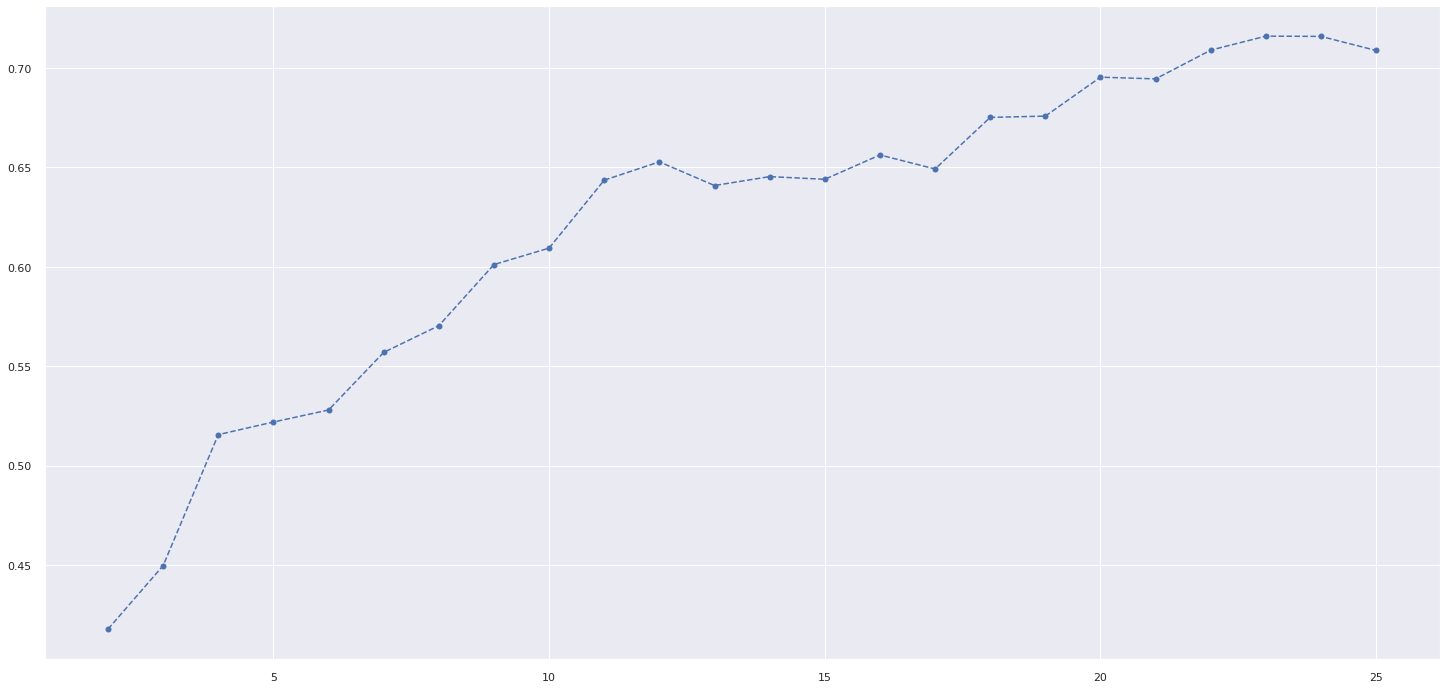

In [373]:
 plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4 DBSCAN

In [382]:
 eps=2
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette score: {}'.format(sil))
print( 'Number of clusters: {}'.format(len( unique( labels ) ) ) )

print( unique(labels))

Silhouette score: 0.6406059861183167
Number of clusters: 11
[ 0  1  2  3  4  5  6  7  8  9 10]


In [383]:
from sklearn.neighbors import NearestNeighbors

In [384]:
neighbors = NearestNeighbors( n_neighbors = min_samples).fit ( X )
distances , indices = neighbors.kneighbors( X )


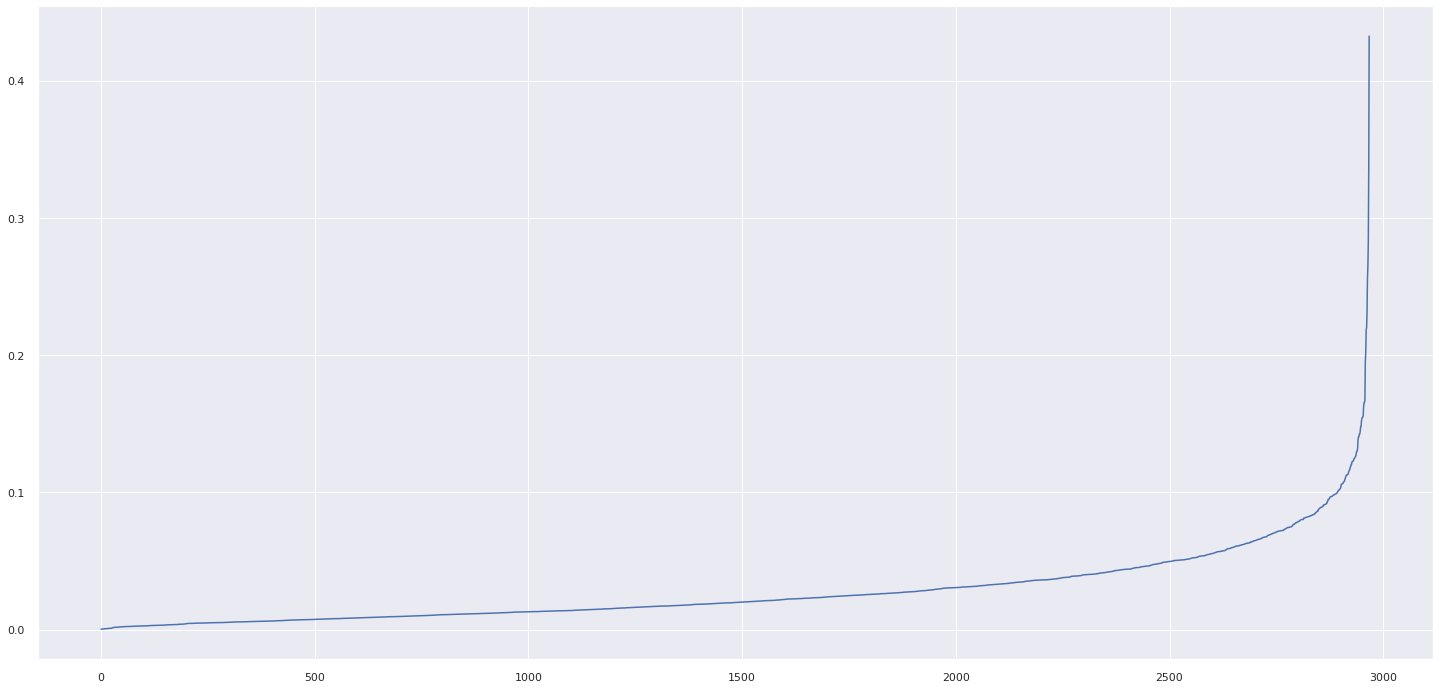

In [385]:
distances = np.sort( distances, axis = 0)
distances = distances[ :, 1]
plt.plot( distances)
   

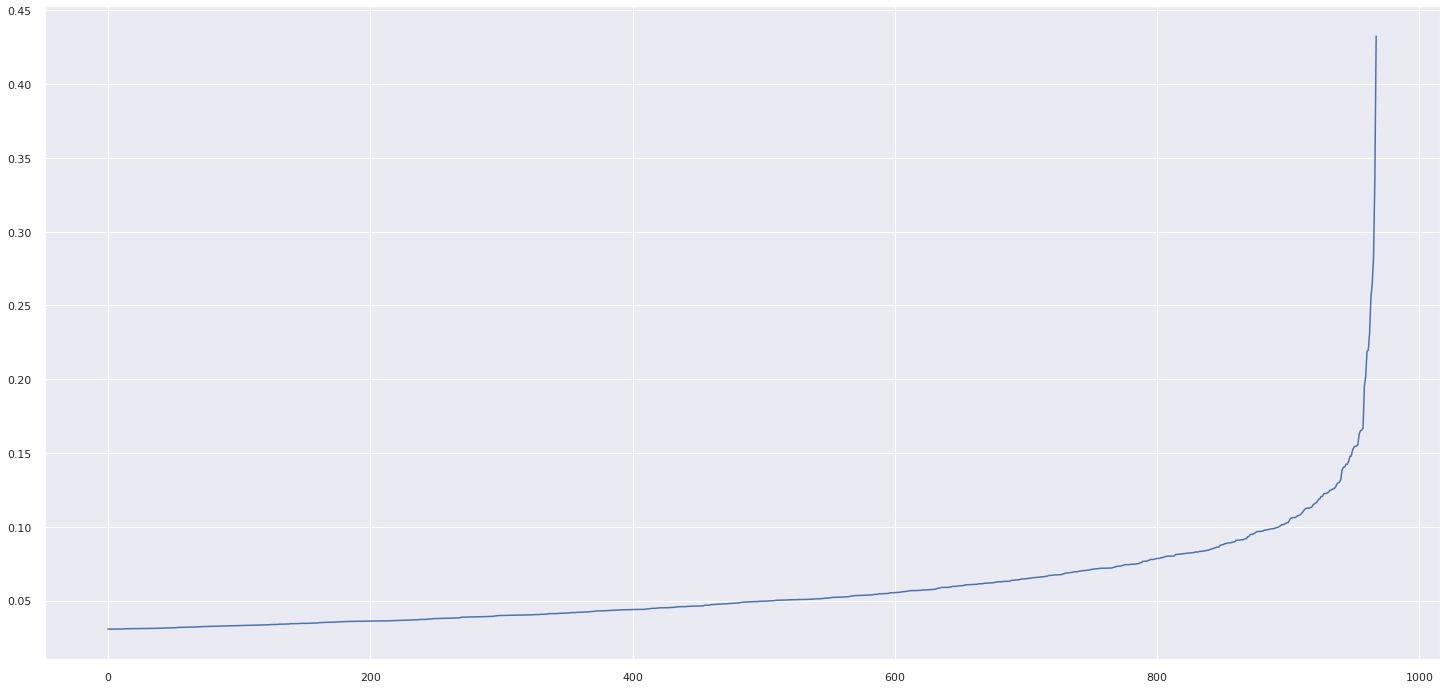

In [386]:
plt.plot( distances[2000:] ) 

In [387]:
dbscan_list = [ 0.754075, 0.000000,0.00000,0.000000,0.00000,0.000000]

In [388]:
X.head()

,embedding_x,embedding_y
0,-5.434389,8.547874
1,-2.569062,14.138089
2,-1.873227,-5.498095
3,25.112038,8.696949
4,9.065816,-8.257551


## 7.5 Results

In [389]:
 # Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list,
     'HC': hc_list,
     'DBSCAN': dbscan_list} 
).T

df_results.columns = clusters

ValueError: All arrays must be of the same length

In [390]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.434424,0.468190,0.516009,0.543473,0.563533,0.561247
GMM,0.427861,0.456563,0.462582,0.493472,0.508787,0.527664
HC,0.417681,0.449640,0.515551,0.521906,0.527953,0.556946
DBSCAN,0.754075,0.000000,0.000000,0.000000,0.000000,0.000000


# 7.1 Silhouette Analysis

For K = 2. Silhouette Score: 0.41768088936805725
For K = 3. Silhouette Score: 0.4496401846408844
For K = 4. Silhouette Score: 0.5155513882637024
For K = 5. Silhouette Score: 0.5219058394432068
For K = 6. Silhouette Score: 0.5279533863067627
For K = 7. Silhouette Score: 0.5569462776184082


IndexError: index 3 is out of bounds for axis 0 with size 3

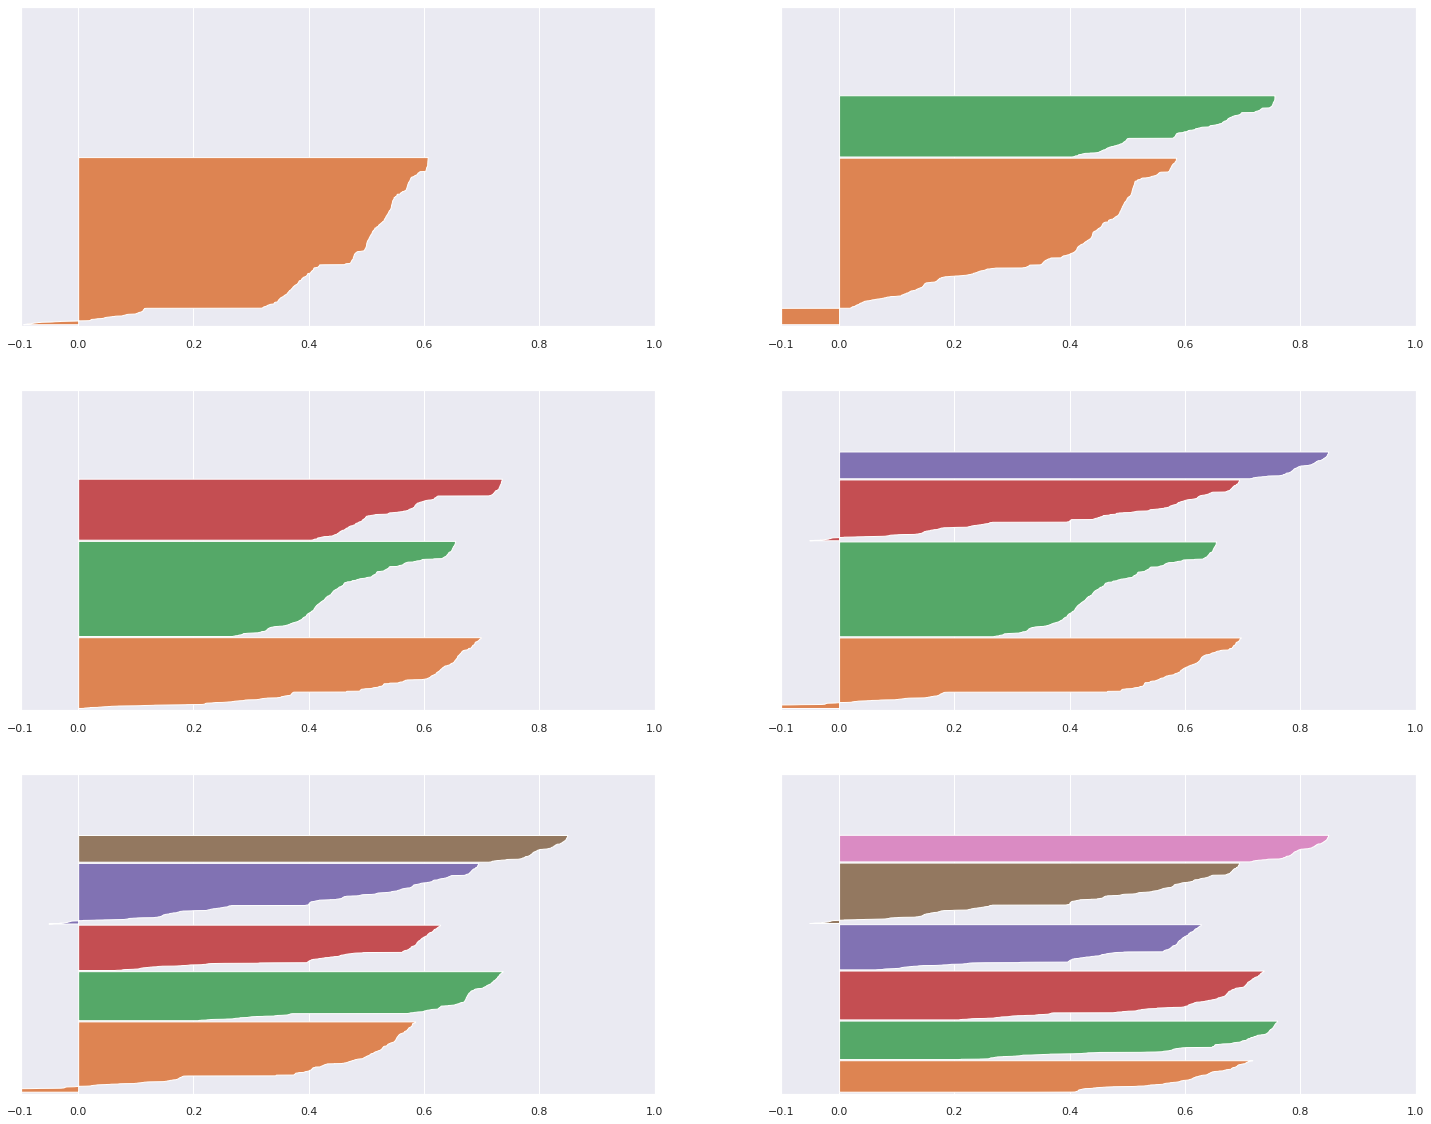

In [391]:
fig, ax = plt.subplots( 3, 2)
fig.set_size_inches( 25,20)

for k in clusters:
    q,mod = divmod(k, 2)
    
    ax[ q-1, mod].set_xlim( [ -0.1,1] )
    ax[ q-1,mod].set_ylim( [0, len( X ) + ( k+1 ) * 10 ] )
    
    # Model definition and training
    hc_model = hc.linkage( X, 'ward')
    
    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion = 'maxclust')
    
    # Performance
    ss = m.silhouette_score( X, labels, metric = 'euclidean' )
    print( 'For K = {}. Silhouette Score: {}'.format ( k, ss ) )
    
    samples_silhouette_values = m.silhouette_samples( X, labels)
    
    y_lower= 10
    for i in range( k ):
        
        # Select Clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # Sort Values
        ith_samples_silhouette_values.sort()
        
        #  Size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i/k)
        
        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ) , 0, ith_samples_silhouette_values )
        
        y_lower = y_upper + 10
        
        
    ax[ q-1, mod].set_yticks( [] )
    ax[ q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0. Model Training

In [ ]:
df8 = df7.copy()

## 8.1. K-Means

In [415]:
# Model Definition
k = 7
kmeans = c.KMeans( init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42  )

# Model Training
kmeans.fit(X)

# Clustering
labels  = kmeans.labels_


## 8.2. Cluster Validation

In [416]:
 ## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 38022.6875
SS value: 0.590056300163269


# 9.0. Cluster Analysis

In [417]:
# df9 = df4.copy()
# df9['cluster'] = labels
# df9.head()

In [418]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,-5.434389,8.547874,3
1,-2.569062,14.138089,3
2,-1.873227,-5.498095,0
3,25.112038,8.696949,2
4,9.065816,-8.257551,1


## 9.1. Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

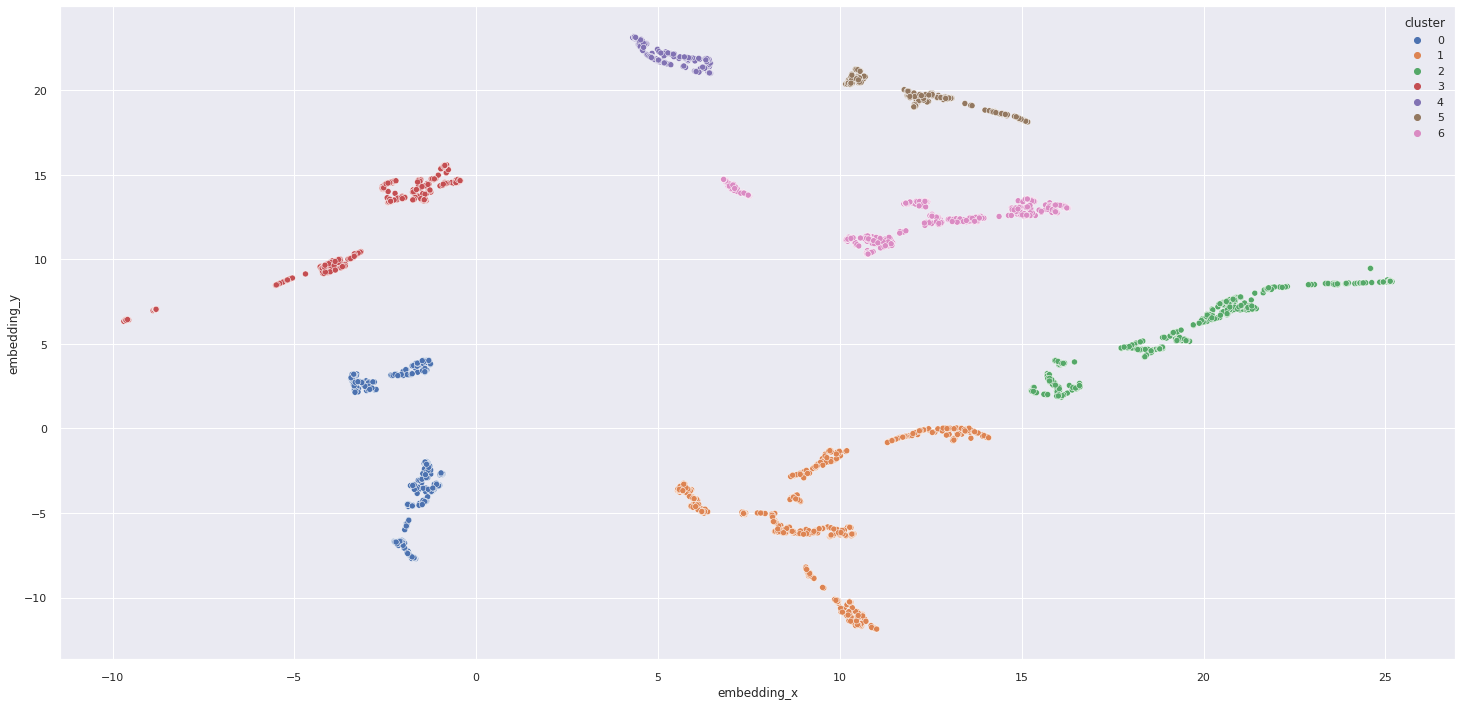

In [419]:
sns.scatterplot( x= 'embedding_x', y= 'embedding_y', hue = 'cluster', data = df9, palette = 'deep')

/home/leandro/.pyenv/versions/pa005insiderscluestering/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


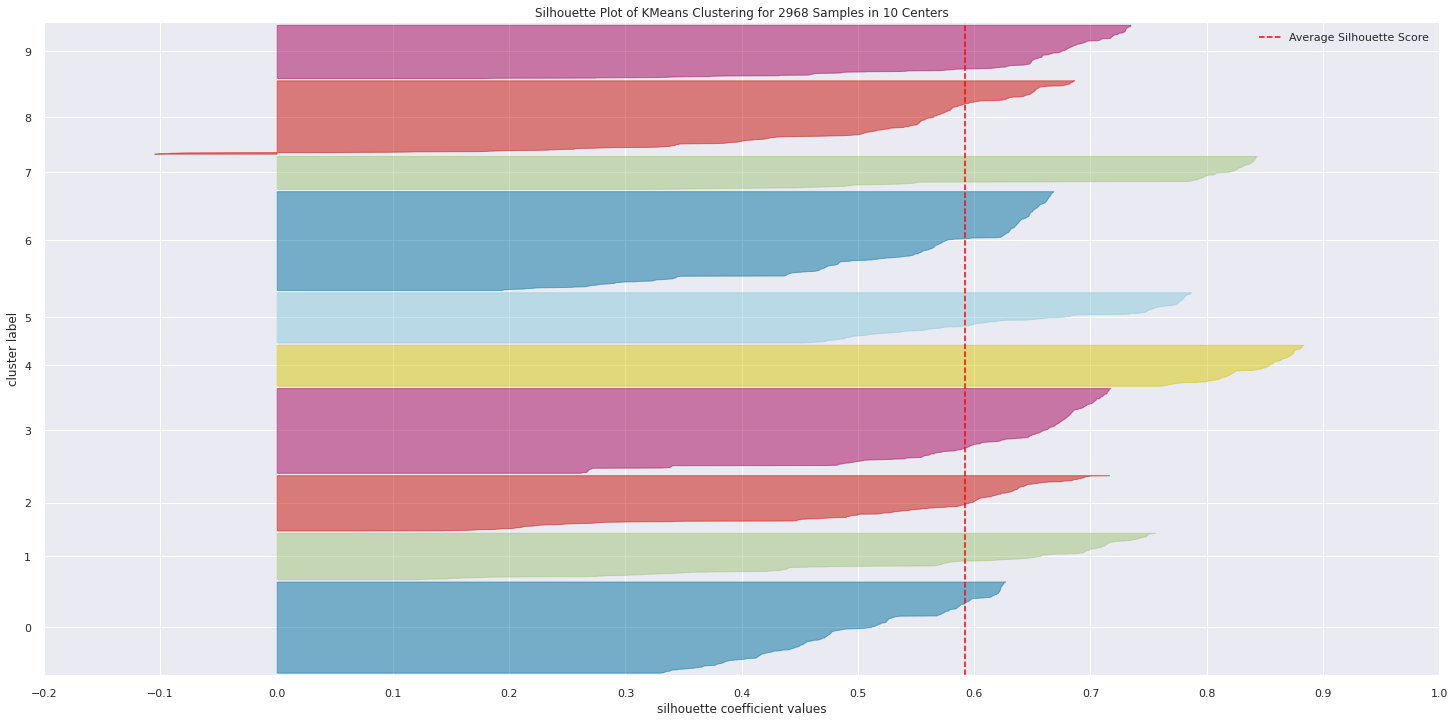

In [409]:
visualizer = SilhouetteVisualizer(kmeans, colors ='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

In [396]:
#fig = px.scatter_3d( df9, x = 'recency_days', y = 'invoice_no', z = 'gross_revenue', color = 'cluster')
#fig.show()

## 9.2. 2D Plot

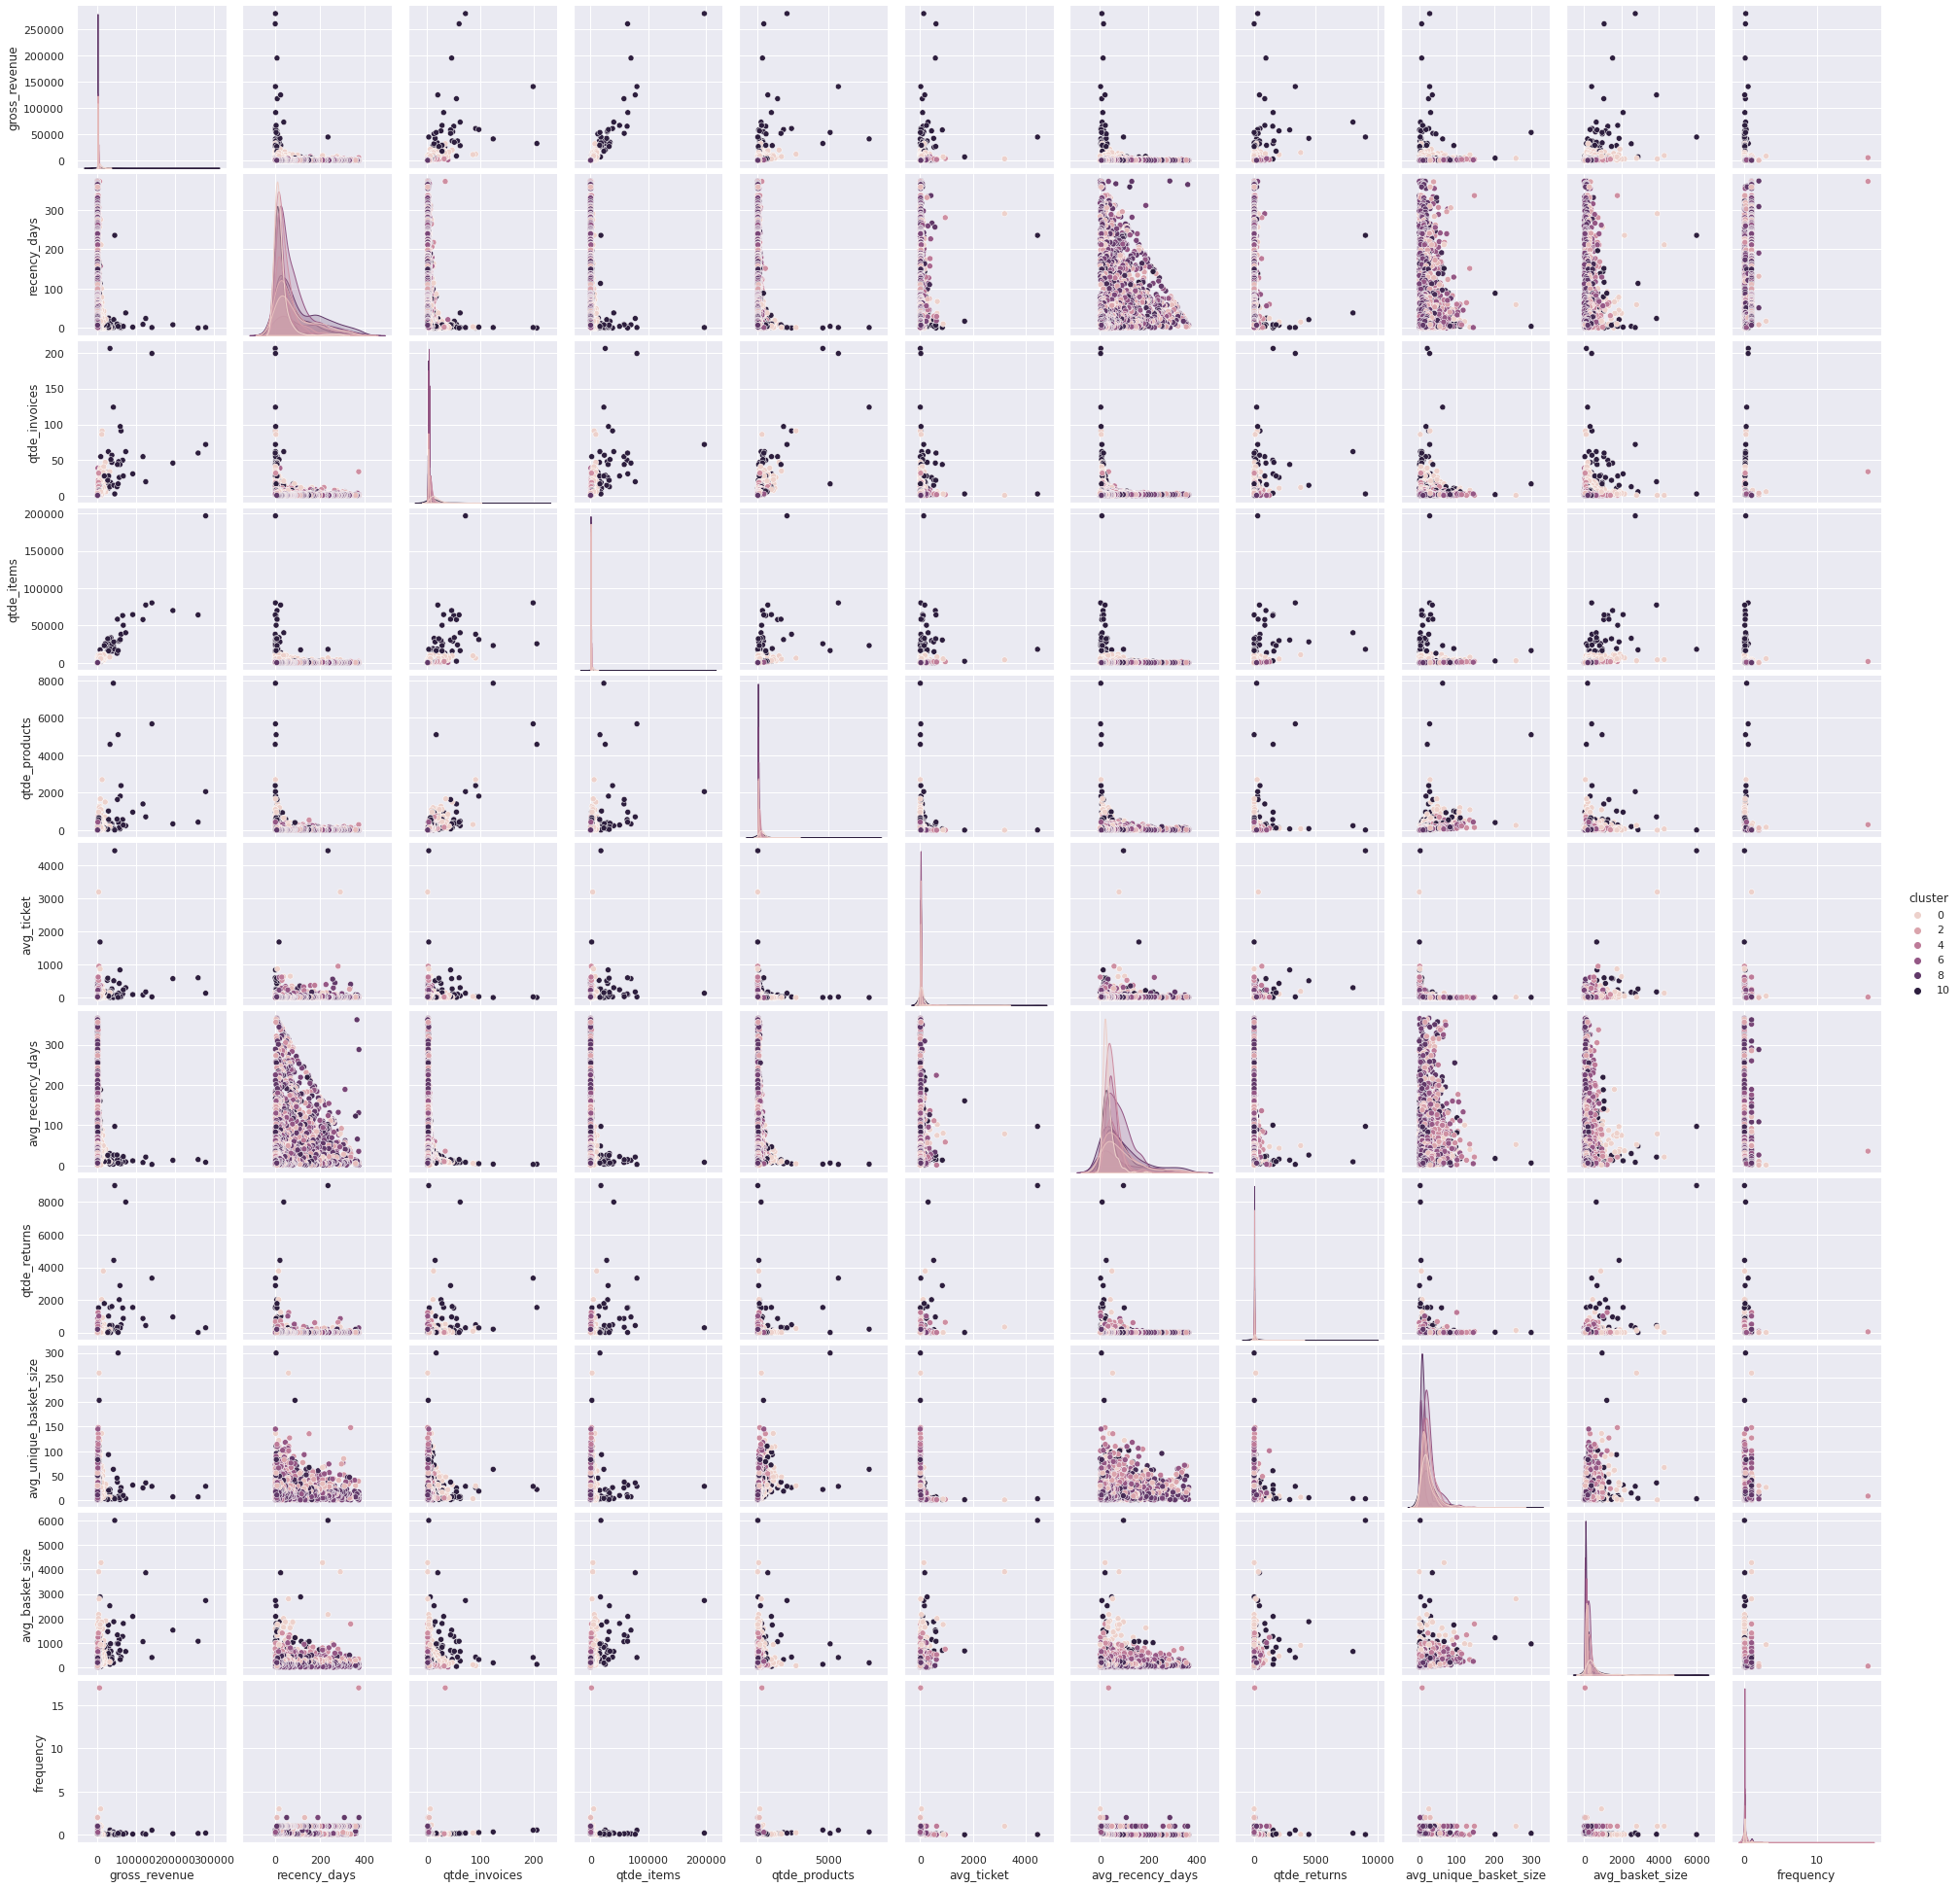

In [397]:
df_viz = df9.drop( columns = 'customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

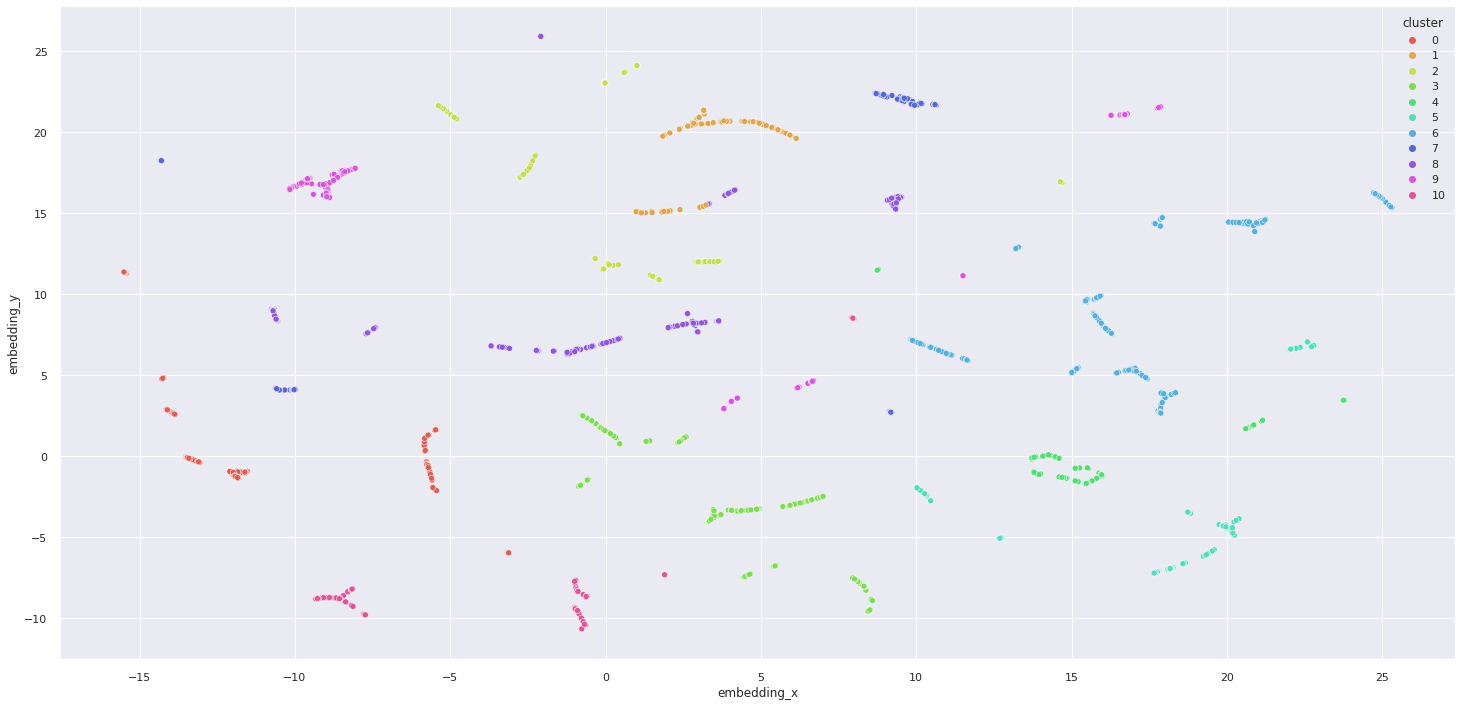

In [398]:
reducer = umap.UMAP( n_neighbors = 20, random_state= 42)
embedding = reducer.fit_transform( X )

# embedding

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot ( x = 'embedding_x', y = 'embedding_y',
                hue= 'cluster', palette = sns.color_palette( 'hls', n_colors= len(df_viz['cluster'].unique())), data= df_viz)

## 9.3. Cluster Profile

In [399]:
# Number of customer
df_cluster = df9[['customer_id','cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['pec_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

# Average gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how = 'inner', on = 'cluster')

# Average recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how = 'inner', on = 'cluster')

# Quantidade de produtos
df_avg_invoice_no = df9[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how = 'inner', on = 'cluster')

# Frequency
df_avg_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how = 'inner', on = 'cluster')


# returns
df_avg_invoice_no = df9[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how = 'inner', on = 'cluster')


df_cluster.head()

,cluster,customer_id,pec_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,255,8.591644,7760.927451,22.698039,336.725490,0.076508,81.882353
1,1,220,7.412399,554.361864,93.109091,45.540909,0.151655,7.581818
2,2,262,8.827493,654.568092,82.118321,53.534351,0.116903,3.843511
3,3,364,12.264151,2589.838654,40.629121,161.373626,0.085713,22.862637
4,4,194,6.536388,1901.593711,40.412371,111.716495,0.039108,28.036082


### Cluster 01:  ( Candidato a Insider )
 
 - Número de customer: 6 (0.13% dos customers)
 - Recência em média: 7 dias
 - Compras em média: 89 compras
 - Receita em média: $ 182.181,00.
 
### Cluster 02:  
 
 - Número de customer: 31 (0.7% dos customers)
 - Recência em média: 14 dias
 - Compras em média: 53 compras
 - Receita em média: $ 40.543,00.
 
 ### Cluster 03: 
 
 - Número de customer: 4.335 (99% dos customers)
 - Recência em média: 92 dias
 - Compras em média: 05 compras
 - Receita em média: $ 1.372,57.

# 10.0. Deploy to Production

In [326]:
df10 = df9.copy()